# Natural Language Processing using RNN and Transformer, Part 2
  
In this part of the project, we will optimize and train a transformer model for the emotions dataset. For this, we will prepare the data in the same way by preprocessing the 'text' column and applying BPE (Byte Pair Encoding).

## Load and Preprocess Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers
from collections import Counter

In [2]:
df = pd.read_csv('/kaggle/input/emotions/text.csv') 
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


The preprocess_text function serves to clean and prepare the input text effectively, ensuring that it is standardized and free of unnecessary elements, while preserving all relevant words for subsequent processing with BPE. 

In [3]:
def preprocess_text(text):
    if not isinstance(text, str):
        raise ValueError("Input must be a string")
    
    # Convert the text to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove all punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

df['text_prepro'] = df['text'].apply(preprocess_text)
df.drop('text', axis=1, inplace=True)

In [4]:
df['text_length']=df['text_prepro'].apply(lambda x: len(x.split()))

max_length = df['text_length'].max()

print('Maximum of feature text_length in dataframe df is:', max_length)

Maximum of feature text_length in dataframe df is: 178


In [5]:
# Split the data into training and validation sets
train_texts, valid_texts, train_labels, valid_labels = train_test_split(df['text_prepro'], df['label'], test_size=0.2, random_state=42)

# Split the validation data into validation and test data
valid_texts, test_texts, valid_labels, test_labels = train_test_split(valid_texts, valid_labels, test_size=0.5, random_state=42)

Byte Pair Encoding (BPE) merges the most frequent pair of characters or character sequences into a single token, progressively building up a vocabulary of common subwords:

In [6]:
# Function to calculate token frequencies
def calculate_token_frequencies(texts, tokenizer):
    token_counts = Counter()
    for text in texts:
        tokens = tokenizer.pre_tokenizer.pre_tokenize_str(text)
        for token in tokens:
            token_counts[token[0]] += 1
    return token_counts

# Tokenizer setup for Byte Pair Encoding (BPE)
bpe_tokenizer = Tokenizer(models.BPE())
bpe_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
bpe_tokenizer.decoder = decoders.BPEDecoder()

# Calculate token frequencies in the training dataset
token_counts = calculate_token_frequencies(train_texts, bpe_tokenizer)

# Add 20% buffer to number of tokens
vocab_size = int(len(token_counts) * 1.2)

print(f"Vocab Size: {vocab_size}")

# Train the BPE tokenizer with the determined vocab size
trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["<pad>", "<unk>"])
bpe_tokenizer.train_from_iterator(train_texts, trainer)

# Function to encode texts with the BPE tokenizer
def bpe_encode(texts, tokenizer, max_length):
    encodings = [tokenizer.encode(text).ids for text in texts]
    padded_encodings = tf.keras.preprocessing.sequence.pad_sequences(encodings, maxlen=max_length, padding='post')
    return padded_encodings

# Encode the texts
train_encodings = bpe_encode(train_texts, bpe_tokenizer, max_length)
valid_encodings = bpe_encode(valid_texts, bpe_tokenizer, max_length)
test_encodings = bpe_encode(test_texts, bpe_tokenizer, max_length)

# Use to_categorical on labels
train_labels = tf.keras.utils.to_categorical(train_labels)
valid_labels = tf.keras.utils.to_categorical(valid_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

Vocab Size: 4633





# Model Definition: Transformer

In [7]:
pip install optuna-integration

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 2.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, Embedding, Masking
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import optuna
from optuna_integration.tfkeras import TFKerasPruningCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Set the global seed
seed = 42

# Control randomness in TensorFlow
tf.random.set_seed(seed)

# Control randomness in NumPy
np.random.seed(seed)



The following code defines three custom layers for building a Transformer model in TensorFlow/Keras: TokenAndPositionEmbedding, MultiHeadSelfAttention and TransformerBlock.

**The TokenAndPositionEmbedding class** is a custom layer that combines token embeddings and positional embeddings. It initializes two embedding layers: one for tokens and one for positions and it sums these embeddings to provide a final embedding that incorporates both token identity and position information. This layer ensures that the model can understand the order of tokens in a sequence.

**The MultiHeadSelfAttention class** defines a multi-head self-attention mechanism. This layer splits the input into multiple attention heads, allowing the model to focus on different parts of the input sequence simultaneously. The layer uses the MultiHeadAttention layer from TensorFlow, which handles the computation of attention scores and the aggregation of the attended values.

**The TransformerBlock class** encapsulates a single block of the Transformer architecture, consisting of a multi-head self-attention layer followed by a feed-forward neural network. It applies layer normalization and dropout to both the attention and feed-forward outputs. The multi-head self-attention mechanism allows the model to focus on different parts of the sequence in parallel, while the feed-forward network processes these attended values to produce the final output. Dropout layers are included to prevent overfitting and layer normalization ensures stable and efficient training by normalizing the inputs to each layer.

Each class includes methods to build the layers, perform the forward pass (call method) and serialize/deserialize the layer configurations (get_config and from_config methods). The use of @keras.utils.register_keras_serializable() ensures that these custom layers can be saved and loaded properly within Keras models. Overall, these components form the backbone of an encoder-only Transformer model, allowing it to handle sequential data effectively by attending to different parts of the input and maintaining information about token positions.
  
  
  
Let's go over some of the parameters.

**vocab_size:**  
This parameter represents the size of the vocabulary, the total number of unique tokens or words that the model will be able to recognize. It is the number of unique words in our dataset plus any additional tokens (like special tokens for padding).

**max_length:**   
This parameter defines the maximum length of the input sequences that the model will process. If an input sequence is shorter than this length, it will be padded with special padding tokens to reach this length. If it is longer, it will be truncated. This ensures that all input sequences have the same length.

**embed_dim:**  
The embedding dimension is the size of the vector space in which words will be represented. Each word in the vocabulary will be represented as a vector of this length.

**ff_dim:**  
The feed-forward dimension is the size of the inner dense layer within the feed-forward network of the Transformer block. This is the dimensionality of the intermediate representation within the feed-forward neural network that follows the attention mechanism.

**num_classes:**  
This parameter represents the number of output classes for the classification task. It defines the number of neurons in the final output layer of the model, with each neuron representing a different class. In this case, the model is designed to classify inputs into 6 different classes.

**num_heads:**
The num_heads parameter specifies the number of attention heads in the multi-head self-attention mechanism within each Transformer block. Each attention head learns to focus on different parts of the input sequence. With multiple heads, the model can capture different types of relationships and dependencies in the data simultaneously. This can improve the model's ability to understand complex patterns.
The embedding dimension (embed_dim) is divided by the number of heads to determine the dimension of each head. For example, if embed_dim is 128 and num_heads is 4, each head operates on a 32-dimensional space (128/4). Increasing num_heads allows for more granular attention mechanisms but reduces the dimensionality per head.

**num_blocks:**
The num_blocks parameter defines the number of Transformer blocks (or layers) stacked on top of each other. Each block consists of a multi-head self-attention layer followed by a feed-forward network. Increasing the number of blocks increases the depth of the model. Deeper models can capture more complex hierarchical patterns in the data, as they apply multiple layers of transformation to the input.
More blocks allow the model to perform more refined feature extraction. Each block builds on the representations learned by the previous blocks, enabling the model to develop more abstract and higher-level features.

In [9]:
# Definition of the TokenAndPositionEmbedding layer
@keras.utils.register_keras_serializable()  # Makes the custom layer serializable
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super(TokenAndPositionEmbedding, self).__init__(**kwargs)
        self.maxlen = maxlen
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        # Embedding layer for tokens
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for positions
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def build(self, input_shape):
        super(TokenAndPositionEmbedding, self).build(input_shape)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # Generate position indices
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Get positional embeddings
        positions = self.pos_emb(positions)
        # Get token embeddings
        x = self.token_emb(x)
        # Add token embeddings and positional embeddings
        return x + positions

    def get_config(self):
        config = super(TokenAndPositionEmbedding, self).get_config()
        config.update({
            'maxlen': self.maxlen,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Definition of the MultiHeadSelfAttention layer
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        # Multi-head attention layer
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

    def call(self, inputs):
        # Apply self-attention
        return self.att(inputs, inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Definition of the TransformerBlock
@keras.utils.register_keras_serializable()  # Makes the custom layer serializable
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        # Multi-head self-attention layer
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        # Feed-forward network
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),  # First dense layer with ReLU activation
            tf.keras.layers.Dense(embed_dim),  # Second dense layer
        ])
        # Layer normalization layers
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Dropout layers
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def build(self, input_shape):
        super(TransformerBlock, self).build(input_shape)

    def call(self, inputs, training=False):
        # Apply multi-head self-attention
        attn_output = self.att(inputs)
        # Apply dropout to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Apply feed-forward network
        ffn_output = self.ffn(out1)
        # Apply dropout to FFN output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add and normalize
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            'embed_dim': self.att.embed_dim,
            'num_heads': self.att.num_heads,
            'ff_dim': self.ffn.layers[0].units,
            'rate': self.dropout1.rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

The following code defines a function build_transformer_model that constructs the Transformer-based model for Optuna. A series of TransformerBlock layers are added in a loop, determined by the num_blocks parameter. Each TransformerBlock applies multi-head self-attention and a feed-forward network to the input, with dropout for regularization. The output of the Transformer blocks is then pooled globally using **GlobalAveragePooling1D**, which reduces the sequence of vectors to a single vector by averaging.  
Using GlobalAveragePooling1D is used for this task because the goal is text classification — predicting a single emotion label from an entire tweet. The Transformer layers produce a sequence of contextualized embeddings, one for each token. However, for classification, we don’t need predictions at the token level, we need a single fixed-size representation of the entire sequence.  
Global average pooling achieves this by aggregating information across all time steps, effectively capturing the overall semantic content of the tweet rather than focusing on any individual token. Compared to simply taking the last token or a specific position, average pooling provides a more balanced summary of the whole text, which is especially important for short and noisy inputs like tweets where relevant emotional cues may appear anywhere in the sequence.
  
After pooling, dropout is applied to reduce overfitting, followed by a dense layer and ReLU activation. This dense layer includes L2 regularization to further prevent overfitting. The output of the dense layer is then normalized using batch normalization, followed by another dropout layer. Finally, the output layer is defined with a softmax activation function to produce probability distributions over the num_classes categories.

The model is then created using the Model class from Keras, specifying the inputs and outputs and returned from the function.  
Like with the RNN model, we will also use categorical_crossentropy during model compilation as the loss function, along with the Adam optimizer. We utilize learning schedules during model creation to achieve a good solution faster than with a constant learning rate.  
  
**Note:**  
In this code, the hyperparameter search space has been restricted compared to an earlier, larger space. Initially, a broader hyperparameter space was used to allow Optuna to explore more diverse configurations. However, since Optuna's optimization process is computationally intensive, and given the limited available resources, the search space was progressively narrowed down to a more manageable size. This restriction helps reduce the computational burden while still focusing on tuning the most critical parameters. It strikes a balance between optimizing model performance and conserving resources.  
  
In general, it is not common practice to define the **Optuna objective function** as a combination of validation loss and validation accuracy, because these metrics are on very different scales and measure different aspects of model performance. However, in this case it was feasible because the hyperparameter search space was already constrained to reasonable values. With these constraints, the validation loss consistently dropped below 1.0 within the first few epochs, which ensured that both metrics stayed in a comparable range. Under these conditions, combining them into a single objective was acceptable for guiding the optimization:  
Our objective function is a **linear combination of the validation loss and validation accuracy**:  
Lower loss values indicate better predictions and higher accuracy indicates better performance.  
So the final objective is a weighted sum where we are minimizing the loss but also penalizing poor accuracy.  
Using both loss and accuracy ensures that the model doesn't just focus on one metric. If we only optimized for accuracy, the model could make trivial decisions (predicting the most frequent class) and still achieve high accuracy without learning useful patterns.
Loss is a finer-grained measure that can still decrease even when accuracy doesn't improve, helping the model learn better representations. Accuracy, on the other hand, gives a more intuitive understanding of model performance.
By assigning weights to loss and accuracy (1.0 for loss and 0.5 for accuracy), we maintain more control over the model's learning process: We emphasize minimizing the loss but still reward the model for improving accuracy.  
This approach combines two objectives into a single objective.

In [10]:
def build_transformer_model(trial):
    # Define hyperparameters using Optuna
    embed_dim = trial.suggest_categorical('embed_dim', [144, 160])  # Embedding dimension
    # ff_dim should be less than or equal to embed_dim
    ff_dim = trial.suggest_int('ff_dim', 112, embed_dim, step=16)  # Dimension of the feed-forward layer
    # dense_units should be less than or equal to ff_dim
    dense_units = trial.suggest_int('dense_units', 80, ff_dim, step=8)  # Number of units in the Dense layer
    
    # Each head processes same number of dimensions
    num_heads = trial.suggest_int('num_heads', 4, 8, step=2)
    while embed_dim % num_heads != 0:
        num_heads = trial.suggest_int('num_heads', 4, 4, step=2)
    
    num_blocks = trial.suggest_int('num_blocks', 3, 4, step=1)            # Number of Transformer blocks
    dropout_rate_1 = trial.suggest_float("dropout_rate_1", 0.1, 0.2, step=0.1)  # Dropout rate for first Dropout
    dropout_rate_2 = trial.suggest_float("dropout_rate_2", 0.1, 0.2, step=0.1)  # Dropout rate for second Dropout
    kernel_regularizer_l2 = trial.suggest_float('kernel_regularizer_l2', 1e-9, 1e-6, log=True)  # L2 regularization
    batch_size = trial.suggest_categorical('batch_size', [32, 64])  # Batch size
    
    # Build the model architecture
    inputs = Input(shape=(max_length,))  # Input layer
    embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)(inputs)  # Token and positional embeddings
    x = embedding_layer

    # Add Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)

    # Add pooling and dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate_1)(x)  # Use Optuna-optimized dropout rate for first Dropout
    x = Dense(dense_units, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer_l2))(x)  # Optimized units and L2 regularization
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate_2)(x)  # Use Optuna-optimized dropout rate for second Dropout
    outputs = Dense(6, activation="softmax")(x)  # Output layer for 6 classes

    model = Model(inputs=inputs, outputs=outputs)
    
    # Define learning rate schedule using Optuna
    initial_learning_rate = trial.suggest_float("initial_learning_rate", 1e-5, 1e-3, log=True)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=20_000,
        decay_rate=0.1,
        staircase=False
    )

    # Compile the model with Adam optimizer
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer_adam,
        metrics=['accuracy']
    )
    
    return model, batch_size  # Return batch_size along with the model


# Function to optimize the model using Optuna
def tform_objective(trial):
    # Build the model and get the batch size
    model, batch_size = build_transformer_model(trial)
    
    # Pruning callback to halt trials early if they are not promising
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')
    
    # Define class weights to handle class imbalance
    class_weight = {0: 1.0, 1: 1.0, 2: 2.0, 3: 1.0, 4: 1.0, 5: 2.0}
    
    # Train the model
    history = model.fit(
        train_encodings,
        train_labels,
        epochs=5,
        validation_data=(valid_encodings, valid_labels),
        batch_size=batch_size,
        callbacks=[pruning_callback],
        class_weight=class_weight,
        verbose=1
    )
    
    # Calculate average validation loss and average validation accuracy over all epochs
    avg_val_loss = sum(history.history['val_loss']) / len(history.history['val_loss'])
    avg_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
    
    # Combine the objectives
    loss_weight = 1.0
    accuracy_weight = 0.5

    # Use average validation loss and the average validation accuracy
    objective = loss_weight * avg_val_loss - accuracy_weight * avg_val_accuracy

    return objective

This code initializes and runs the Optuna study for the Transformer model. It first clears any previous session data to avoid conflicts and sets a random seed to ensure reproducibility of the results. The optuna.create_study function is used to create a study object aimed at minimize the objective of the model. The optimization process is then started with a specified number of trials, where the tform_objective function is executed to evaluate different sets of hyperparameters. After the optimization process is complete, the best hyperparameters and the lowest objective achieved are printed out. This allows us to identify the optimal configuration for our Transromer model based on validation performance.

In [11]:
# Clear any previous session data to avoid conflicts
tf.keras.backend.clear_session()

# Set the random seed for reproducibility
tf.random.set_seed(42)

# Create an Optuna study object to find the best hyperparameters
# Since we are minimizing a combined objective, set direction to 'minimize'
tform_study = optuna.create_study(direction='minimize')

# Start the optimization process, running the objective function (tform_objective) over multiple trials
tform_study.optimize(tform_objective, n_trials=4)

# Print the best hyperparameters found during the optimization process
print('Best hyperparameters tform: ', tform_study.best_params)

# Print the best value of the combined objective achieved with the optimal hyperparameters
print('Best combined objective value tform: ', tform_study.best_value)

[I 2024-10-11 05:02:01,485] A new study created in memory with name: no-name-3ec771dc-2bb7-439d-b46a-63d813619131


Epoch 1/5


I0000 00:00:1728622932.170583     113 service.cc:145] XLA service 0x7ff5a000be10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728622932.170644     113 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


    7/10421 ━━━━━━━━━━━━━━━━━━━━ 4:35 26ms/step - accuracy: 0.2006 - loss: 2.6644 

I0000 00:00:1728622949.137598     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10421/10421 ━━━━━━━━━━━━━━━━━━━━ 298s 26ms/step - accuracy: 0.7419 - loss: 0.7577 - val_accuracy: 0.9078 - val_loss: 0.1817
Epoch 2/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 256s 25ms/step - accuracy: 0.9050 - loss: 0.2243 - val_accuracy: 0.9107 - val_loss: 0.1755
Epoch 3/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 242s 23ms/step - accuracy: 0.9103 - loss: 0.2070 - val_accuracy: 0.9107 - val_loss: 0.1733
Epoch 4/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 241s 23ms/step - accuracy: 0.9115 - loss: 0.2010 - val_accuracy: 0.9102 - val_loss: 0.1730
Epoch 5/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 241s 23ms/step - accuracy: 0.9128 - loss: 0.1994 - val_accuracy: 0.9105 - val_loss: 0.1728


[I 2024-10-11 05:23:21,122] Trial 0 finished with value: -0.2797520846128464 and parameters: {'embed_dim': 160, 'ff_dim': 160, 'dense_units': 144, 'num_heads': 4, 'num_blocks': 3, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'kernel_regularizer_l2': 2.666890148945048e-07, 'batch_size': 32, 'initial_learning_rate': 0.00015884327213776315}. Best is trial 0 with value: -0.2797520846128464.


Epoch 1/5
    5/10421 ━━━━━━━━━━━━━━━━━━━━ 4:49 28ms/step - accuracy: 0.1502 - loss: 2.9477  

I0000 00:00:1728624231.738897     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 40 bytes spill stores, 40 bytes spill loads



10421/10421 ━━━━━━━━━━━━━━━━━━━━ 345s 30ms/step - accuracy: 0.2005 - loss: 2.2868 - val_accuracy: 0.6094 - val_loss: 1.1381
Epoch 2/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 296s 28ms/step - accuracy: 0.6153 - loss: 1.2117 - val_accuracy: 0.7793 - val_loss: 0.7335
Epoch 3/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 296s 28ms/step - accuracy: 0.7458 - loss: 0.8677 - val_accuracy: 0.8099 - val_loss: 0.6354
Epoch 4/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 295s 28ms/step - accuracy: 0.7780 - loss: 0.7716 - val_accuracy: 0.8185 - val_loss: 0.6088
Epoch 5/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 296s 28ms/step - accuracy: 0.7856 - loss: 0.7477 - val_accuracy: 0.8211 - val_loss: 0.6006


[I 2024-10-11 05:48:50,314] Trial 1 finished with value: 0.3594309449195862 and parameters: {'embed_dim': 144, 'ff_dim': 112, 'dense_units': 104, 'num_heads': 4, 'num_blocks': 4, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.2, 'kernel_regularizer_l2': 1.0154722787213885e-09, 'batch_size': 32, 'initial_learning_rate': 1.0812412322280747e-05}. Best is trial 0 with value: -0.2797520846128464.


Epoch 1/5
    5/10421 ━━━━━━━━━━━━━━━━━━━━ 4:54 28ms/step - accuracy: 0.1109 - loss: 3.0012  

I0000 00:00:1728625760.807910     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_17', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_15', 64 bytes spill stores, 64 bytes spill loads



10421/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4907 - loss: 1.4482

I0000 00:00:1728626070.494603     111 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 64 bytes spill stores, 64 bytes spill loads



10421/10421 ━━━━━━━━━━━━━━━━━━━━ 351s 31ms/step - accuracy: 0.4907 - loss: 1.4481 - val_accuracy: 0.9026 - val_loss: 0.2375
Epoch 2/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 301s 29ms/step - accuracy: 0.8985 - loss: 0.2958 - val_accuracy: 0.9060 - val_loss: 0.2203
Epoch 3/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 302s 29ms/step - accuracy: 0.9016 - loss: 0.2703 - val_accuracy: 0.9065 - val_loss: 0.2111
Epoch 4/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 299s 29ms/step - accuracy: 0.9022 - loss: 0.2649 - val_accuracy: 0.9063 - val_loss: 0.2101
Epoch 5/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 300s 29ms/step - accuracy: 0.9034 - loss: 0.2623 - val_accuracy: 0.9062 - val_loss: 0.2099


[I 2024-10-11 06:14:46,415] Trial 2 finished with value: -0.2350001662969589 and parameters: {'embed_dim': 144, 'ff_dim': 144, 'dense_units': 96, 'num_heads': 4, 'num_blocks': 4, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.1, 'kernel_regularizer_l2': 9.250952389225204e-09, 'batch_size': 32, 'initial_learning_rate': 2.2414521389733457e-05}. Best is trial 0 with value: -0.2797520846128464.


Epoch 1/5
    3/10421 ━━━━━━━━━━━━━━━━━━━━ 5:53 34ms/step - accuracy: 0.1892 - loss: 2.7962   

I0000 00:00:1728627310.458185     110 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 116 bytes spill stores, 116 bytes spill loads



10421/10421 ━━━━━━━━━━━━━━━━━━━━ 398s 36ms/step - accuracy: 0.7397 - loss: 0.7470 - val_accuracy: 0.9079 - val_loss: 0.1836
Epoch 2/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 359s 34ms/step - accuracy: 0.9049 - loss: 0.2248 - val_accuracy: 0.9106 - val_loss: 0.1758
Epoch 3/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 359s 34ms/step - accuracy: 0.9088 - loss: 0.2088 - val_accuracy: 0.9113 - val_loss: 0.1750
Epoch 4/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 359s 34ms/step - accuracy: 0.9120 - loss: 0.2020 - val_accuracy: 0.9117 - val_loss: 0.1750
Epoch 5/5
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 361s 35ms/step - accuracy: 0.9125 - loss: 0.1999 - val_accuracy: 0.9117 - val_loss: 0.1753


[I 2024-10-11 06:45:23,504] Trial 3 finished with value: -0.2783658921718597 and parameters: {'embed_dim': 144, 'ff_dim': 144, 'dense_units': 128, 'num_heads': 8, 'num_blocks': 3, 'dropout_rate_1': 0.1, 'dropout_rate_2': 0.2, 'kernel_regularizer_l2': 2.4964101764568574e-07, 'batch_size': 32, 'initial_learning_rate': 0.00032813533893048417}. Best is trial 0 with value: -0.2797520846128464.


Best hyperparameters tform:  {'embed_dim': 160, 'ff_dim': 160, 'dense_units': 144, 'num_heads': 4, 'num_blocks': 3, 'dropout_rate_1': 0.2, 'dropout_rate_2': 0.1, 'kernel_regularizer_l2': 2.666890148945048e-07, 'batch_size': 32, 'initial_learning_rate': 0.00015884327213776315}
Best combined objective value tform:  -0.2797520846128464


**Key Takeaway:**  
When the batch size is set to 32, each epoch consists of about 10.419 training steps (training dataset size=333.400 and 333.400 / 32 = 10.419), which results in roughly 52.000 steps over five epochs. Since the exponential decay schedule is configured with decay_steps=20000, the learning rate starts decaying already during the second epoch. This means the model spends the later epochs training with a very small learning rate, which can slow down learning and limit the model’s ability to escape local minima.  
With a batch size of 64, each epoch has about 5.209 steps, leading to roughly 26.000 steps after five epochs. In this case, the learning rate only crosses the 20.000-step threshold towards the end of training, so the decay is less pronounced. This creates a more moderate schedule where the learning rate remains relatively stable for most of training, providing stronger updates and potentially better convergence compared to the smaller batch size case. 
  
Ideally, the parameters of the learning rate schedule — namely decay_steps, decay_rate and also a final target learning rate — should be included in the hyperparameter optimization as well, but this was not done here due to computational resource limitations.  
  
Here the optimal batch_size is 32. 
  
By retrieving the best hyperparameters identified during the study, a Transformer model is built. The learning rate schedule is defined using exponential decay based on the optimal learning rate found during hyperparameter tuning. The Adam optimizer is then initialized with this learning rate schedule. The model is compiled with categorical crossentropy as the loss function and accuracy as the evaluation metric.  
Finally, the tform_model.summary() function is called to display a summary of the model's architecture, providing an overview of the layers and parameters used.

In [12]:
def build_transformer_model_final(params):
    embed_dim = params['embed_dim']
    ff_dim = params['ff_dim']
    dense_units = params['dense_units']
    num_heads = params['num_heads']
    num_blocks = params['num_blocks']
    dropout_rate_1 = params['dropout_rate_1']
    dropout_rate_2 = params['dropout_rate_2']
    kernel_regularizer_l2 = params['kernel_regularizer_l2']
    batch_size = params['batch_size']
    initial_learning_rate = params['initial_learning_rate']
    
    # Input layer
    inputs = Input(shape=(max_length,))
    
    # Token and positional embeddings
    embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)(inputs)
    x = embedding_layer

    # Add Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)

    # Pooling and Dense layers
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate_1)(x)
    x = Dense(dense_units, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(kernel_regularizer_l2))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(dropout_rate_2)(x)
    
    # Output layer
    outputs = Dense(6, activation="softmax")(x)

    # Build model
    model = Model(inputs=inputs, outputs=outputs)

    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=20_000,
        decay_rate=0.1,
        staircase=False
    )

    # Compile the model with Adam optimizer
    optimizer_adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer_adam,
        metrics=['accuracy']
    )
    
    return model, batch_size

In [13]:
# Retrieve the best hyperparameters found from the Optuna study
tform_best_hyperparams = tform_study.best_params

# Build model with best Hyperparameters
tform_model, batch_size = build_transformer_model_final(tform_best_hyperparams)

# Display the model summary to show the architecture and parameters
tform_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 178)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_4  │ (None, 178, 160)       │       769,760 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_14            │ (None, 178, 160)       │       463,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_15            │ (None, 178, 160)       │       463,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_16            │ (None, 178, 160)       │       463,840 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 160)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 144)            │        23,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 144)            │           576 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 6)              │           870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,185,910 (8.34 MB)

 Trainable params: 2,185,622 (8.34 MB)

 Non-trainable params: 288 (1.12 KB)

In [14]:
# Define weight for underrepresented classes 'love' and 'surprise'
class_weight = {0: 1.0, 1: 1.0, 2: 2.0, 3: 1.0, 4: 1.0, 5: 2.0}


# Define the EarlyStopping callback to monitor validation accuracy and stop training if no improvement is observed
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    mode='min',  
    restore_best_weights=True  # Restore the model weights from the best epoch
)

# Define the ModelCheckpoint callback to save the model with the best validation accuracy
checkpoint = ModelCheckpoint(
    'tform_best_model.keras',  # Path where the best model will be saved
    monitor='val_loss',
    mode='min',  # Save the model with the lowest validation loss
    save_best_only=True,  # Save only the best model (based on the monitored metric)
    verbose=1  # Print messages when saving the model
)

# Final training of the best model
tform_history = tform_model.fit(
    train_encodings, 
    train_labels,   
    validation_data=(valid_encodings, valid_labels),  
    epochs=15,  
    batch_size=batch_size, 
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weight,  # Apply class weights to handle class imbalance
    verbose=1 
)

Epoch 1/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7556 - loss: 0.7093
Epoch 1: val_loss improved from inf to 0.18237, saving model to tform_best_model.keras
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 282s 25ms/step - accuracy: 0.7556 - loss: 0.7092 - val_accuracy: 0.9087 - val_loss: 0.1824
Epoch 2/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9064 - loss: 0.2244
Epoch 2: val_loss improved from 0.18237 to 0.17837, saving model to tform_best_model.keras
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 242s 23ms/step - accuracy: 0.9064 - loss: 0.2244 - val_accuracy: 0.9105 - val_loss: 0.1784
Epoch 3/15
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9105 - loss: 0.2064
Epoch 3: val_loss improved from 0.17837 to 0.17645, saving model to tform_best_model.keras
10421/10421 ━━━━━━━━━━━━━━━━━━━━ 239s 23ms/step - accuracy: 0.9105 - loss: 0.2064 - val_accuracy: 0.9105 - val_loss: 0.1765
Epoch 4/15
10420/10421 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9117 - loss: 0.

We plot training and validation accuracy as well as training and validation loss to see how closely the training cuves are tracking the validation curves.

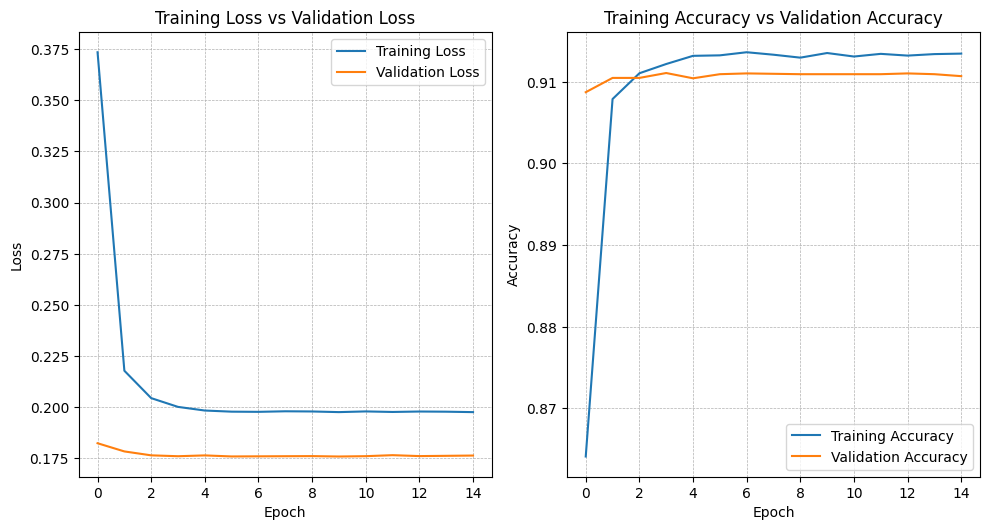

In [15]:
# Function to plot Loss and Accuracy
def plot_training_history(history):
    """
    Plots the training and validation loss and accuracy from the history object.

    Parameters:
    history (History): The history object returned by the fit method of a Keras model.
    """
    fig = plt.figure(figsize=(10, 10), facecolor='white')

    # Plotting Loss
    ax1 = fig.add_subplot(2, 2, 1, facecolor='white')
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.legend(facecolor='white')
    ax1.set_title('Training Loss vs Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, linestyle='--', linewidth=0.5)

    # Plotting Accuracy
    ax2 = fig.add_subplot(2, 2, 2, facecolor='white')
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.legend(facecolor='white')
    ax2.set_title('Training Accuracy vs Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

plot_training_history(tform_history)

In the training process the model shows early improvement, followed by stabilization in later epochs.  
  
Epoch 1 starts with relatively low accuracy and a high loss, but the validation accuracy jumps significantly to 90% and validation loss drops to 0.18. This suggests that the model quickly learned patterns in the data, resulting in substantial early gains.  
By epoch 2 accuracy increases with further validation loss improvement, indicating that the model continues to refine its understanding of the data, albeit with smaller improvements than in the first epoch.  
From epoch 5 onward the model reaches a plateau, with the accuracy hovering around 91% and validation loss fluctuating slightly around 0.176. While the accuracy shows minor gains, the validation loss barely improves after epoch 6.  
While the training loss continues to decrease, the validation loss stays relatively stable from epoch 5 to epoch 15, suggesting that the model has reached its optimal state.  
  
The training process shows that the model rapidly learns key patterns in the first few epochs. The validation accuracy and loss stabilize after about 5 to 6 epochs, signaling that the model has reached a strong performance ceiling early on, with little improvement beyond this point. The EarlyStopping callback helps to avoid overfitting, preserving a model with solid generalization capabilities.

In [16]:
# Load best model from file
tform_best_model = load_model('tform_best_model.keras')

In [17]:
# Predict probabilities for each class  
y_pred_probabilities_valid = tform_best_model.predict(valid_encodings)

# Convert probabilities to class labels by taking the argmax (index of the highest probability)
y_pred_classes_valid = np.argmax(y_pred_probabilities_valid, axis=1)

# Label dictionary
label_dict = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Convert one-hot encoded valid_labels back to numerical class labels
valid_labels_numerical = np.argmax(valid_labels, axis=1)

# Map numerical labels to emotional categories
y_pred_emotions_valid = [label_dict[label] for label in y_pred_classes_valid]
valid_emotions_valid = [label_dict[label] for label in valid_labels_numerical]

# Generate classification report using emotional labels
report_valid = classification_report(valid_emotions_valid, y_pred_emotions_valid)

print("Classification Report for Validation Data:")
print(report_valid)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step
Classification Report for Validation Data:
              precision    recall  f1-score   support

       anger       0.90      0.93      0.91      5761
        fear       0.90      0.84      0.87      4752
         joy       0.98      0.88      0.93     14079
        love       0.73      0.98      0.84      3549
     sadness       0.96      0.94      0.95     12044
    surprise       0.70      0.97      0.81      1496

    accuracy                           0.91     41681
   macro avg       0.86      0.92      0.88     41681
weighted avg       0.92      0.91      0.91     41681



In the validation results, the model shows strong overall performance, with a high accuracy of 91%.  
  
The model performs very well on the "anger" class, with a precision of 0.90 and a recall of 0.93, resulting in an f1-score of 0.91. This indicates that the model effectively detects anger and has a low rate of false positives and negatives.  
The precision (0.90) for "fear" is solid, but the recall (0.84) is lower, leading to an f1-score of 0.87. This suggests the model misses a portion of true "fear" instances, meaning it struggles more with detecting all cases of fear.  
The class "joy" achieves high performance, with a precision of 0.98 and a recall of 0.88. The f1-score (0.93) indicates that the model performs very well on joy, likely due to having a large number of training examples.  
"Love" is one of the underrepresented classes and the recall (0.98) is particularly high, indicating the model captures almost all "love" instances. However, the precision is lower (0.73), meaning that a number of false positives are classified as love, lowering the f1-score (0.84).  
The model achieves very strong performance for "sadness", with both precision (0.96) and recall (0.94) being high, leading to an f1-score of 0.95. This reflects good performance on another well-represented class.  
"Surprise" is another underrepresented class and the results are more mixed. The recall is very high (0.97), meaning the model successfully captures most instances of surprise. However, precision (0.70) is lower, suggesting that there are many false positives, reducing the f1-score (0.81).  
  
Class weighting was applied for the classes "love" and "surprise" during training, where higher weights were assigned to these underrepresented classes to make the model more sensitive to them:  
The higher class weights have led to strong recall for these classes, with the model able to detect nearly all instances of "love" and "surprise". However, the model sacrifices precision, which leads to more false positives in these categories. For well-represented classes like "joy" and "sadness", the model maintains high precision and recall, showing that class weighting helped balance performance across the emotions without compromising the larger classes.
  
The model performs well across most classes, with the class weighting strategy helping to boost performance on smaller classes like "love" and "surprise".

## Test Data

We have trained the model on the training data. Now it is time to evaluate the best model on the test data, making the test data the final and best way to assess the model's generalizability.

In [18]:
# Predict probabilities for each class  
y_pred_probabilities = tform_best_model.predict(test_encodings)

# Convert probabilities to class labels by taking the argmax (index of the highest probability)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Label dictionary
label_dict = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# Convert one-hot encoded test_labels back to numerical class labels
test_labels_numerical = np.argmax(test_labels, axis=1)

# Map numerical labels to emotional categories
y_pred_emotions = [label_dict[label] for label in y_pred_classes]
valid_emotions = [label_dict[label] for label in test_labels_numerical]

# Generate classification report using emotional labels
report_tform = classification_report(valid_emotions, y_pred_emotions)

print("Classification Report for Test Data:")
print(report_tform)

1303/1303 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
Classification Report for Test Data:
              precision    recall  f1-score   support

       anger       0.90      0.93      0.91      5680
        fear       0.90      0.83      0.86      4842
         joy       0.98      0.88      0.93     14085
        love       0.72      0.98      0.83      3380
     sadness       0.95      0.94      0.95     12157
    surprise       0.69      0.97      0.81      1537

    accuracy                           0.91     41681
   macro avg       0.86      0.92      0.88     41681
weighted avg       0.92      0.91      0.91     41681



The results for the test set are very similar to those for the validation set, indicating that the model generalizes well and performs consistently on unseen data.  
  
The test set accuracy is 91%, identical to the validation accuracy, showing the model maintained its performance across different datasets.  
The main differences lie in slight drops in recall for "fear" and precision for "love", but these are minimal and do not significantly affect the overall performance.  
  
In summary, the model's performance on the test data is highly consistent with the validation results, the model has not overfitted and is able to generalize well to unseen data, reflecting robustness across the classes.
  
The model generalizes well and is ready for some custom sentences.

In [19]:
# Function to predict emotion
def predict_emotion(custom_sentence, bpe_tokenizer, max_length, model, label_dict):
    # Preprocess the custom sentence
    preprocessed_sentence = preprocess_text(custom_sentence)
    
    # Encode the preprocessed sentence
    encoded_sentence = bpe_encode([preprocessed_sentence], bpe_tokenizer, max_length)
    
    # Predict the class probabilities
    pred_probabilities = tform_best_model.predict(encoded_sentence)
    
    # Convert probabilities to class label
    pred_class = np.argmax(pred_probabilities, axis=1)[0]
    
    # Map the class label to emotion
    pred_emotion = label_dict[pred_class]
    
    return pred_emotion

In [20]:
custom_sentence_1 = "I wouldn't say that I wasn't happy."
predicted_emotion = predict_emotion(custom_sentence_1, bpe_tokenizer, max_length, tform_best_model, label_dict)

print(f"The predicted emotion for the sentence '{custom_sentence_1}' is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
The predicted emotion for the sentence 'I wouldn't say that I wasn't happy.' is: joy


The model seems to understand double negation, which could be due to the preprocessing of the texts, specifically the use of Byte Pair Encoding (BPE). BPE might break down words in a way that allows the model to capture nuanced patterns like double negation more effectively during tokenization.

In [21]:
custom_sentence_2 = "I feel really good, but the bad weather annoys me a lot."
predicted_emotion = predict_emotion(custom_sentence_2, bpe_tokenizer, max_length, tform_best_model, label_dict)

print(f"The predicted emotion for the sentence '{custom_sentence_2}' is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted emotion for the sentence 'I feel really good, but the bad weather annoys me a lot.' is: sadness


This sentence expresses mixed emotions ("joy" and "anger"), making it a good test for the model that needs to classify only one dominant emotion. In this case, the model identified the emotion "sadness" as the most dominant.

In [22]:
custom_sentence_3 = "I feel both happy and sad at the same time."
predicted_emotion = predict_emotion(custom_sentence_3, bpe_tokenizer, max_length, tform_best_model, label_dict)

print(f"The predicted emotion for the sentence '{custom_sentence_3}' is: {predicted_emotion}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
The predicted emotion for the sentence 'I feel both happy and sad at the same time.' is: sadness


The two most commonly represented emotions are "joy" and "sadness". With this custom sentence, the model now has to decide between one of these two emotions.  

The model predicted sadness. This result aligns with the test set performance, where sadness was one of the best-represented classes and achieved both high precision (0.95) and high recall (0.94). In practice, this means the model is very reliable when it predicts sadness and is also very capable of identifying most sadness-related examples correctly.  
At the same time, the sentence also contains elements of joy, which the model had to consider as well. Interestingly, joy is the largest class in the dataset and the model reached a very high precision (0.98) but a somewhat lower recall (0.88). This indicates that while the model rarely makes false positive predictions of joy, it sometimes misses true joy examples. In the ambiguous case of mixed emotions, the model favored sadness over joy, which is consistent with its stronger recall performance for sadness in the test data.